In [ ]:
!pip install einops > /dev/null

import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import scipy.ndimage as nd
import pandas as pd
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import einops
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.nn.functional as fonctional

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:

def get_cifar10_dataloaders(val_percentage=0.1, batch_size=20):
  input_size = 299

  transform_test = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
  
  transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                        #transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(5),
                        transforms.RandomRotation(7),
                        transforms.Resize(input_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

  dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train) #len=50000

  dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test) #len=10000

  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train

  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

  data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)

  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)

  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)

  return data_loader_train, data_loader_val, data_loader_test

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# _ = get_cifar10_dataloaders()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


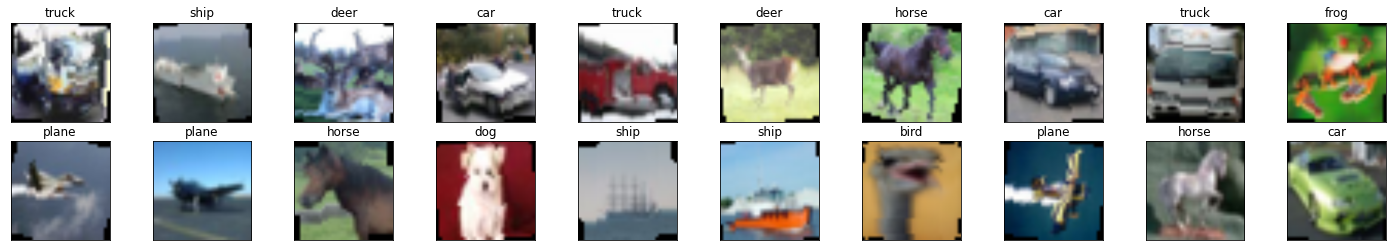

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image / 2 + 0.5     # unnormalize
  image = image.transpose(1, 2, 0)
  return image

a,_,_=get_cifar10_dataloaders( batch_size=20)
dataiter = iter(a)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class Experiment:

    def __init__(self,model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.cuda()
        self.optimizer = None
        self.scheduler = None
        

        self.criterion = torch.nn.CrossEntropyLoss().cuda() if self.use_cuda else torch.nn.MSELoss()
        self.train_losses = []
        self.train_accs = []
        self.train_f1_log = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1_log = []
        self.start_epoch = 1

    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       

        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=1, verbose=True)
        
        best_val_f1 = 0.4

        for epoch in range(self.start_epoch, num_epochs + 1):

            print('Epoch {}/{}'.format(epoch, num_epochs))

            epoch_losses = []
            epoch_accs = []
            epoch_f1 = []
            i = 0
            if verbose :
              pbar = tqdm(train_data_loader)
            else :
              pbar = train_data_loader
            for data in pbar:

                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model.forward(images)

                loss = self.criterion(outputs, labels)
                loss.backward()

                self.optimizer.step()

                epoch_losses.append(loss.data.cpu())
                
                batch_accuracy = accuracy(outputs, labels)

                epoch_accs.append(batch_accuracy) 
                batch_f1 = f1_score_(outputs, labels)
                epoch_f1.append(batch_f1) 

                if verbose:
                  pbar.set_postfix({"Batch loss ":loss.data.cpu().numpy(),' Epoch loss ': np.mean(epoch_losses)," Batch Acc ":batch_accuracy.numpy()," Epoch Acc ":np.mean(epoch_accs),
                                    " Batch f1 ":batch_f1,"  Avg Epoch f1 ":np.mean(epoch_f1)})   

            self.train_losses.append(np.mean(epoch_losses))
            self.train_accs.append(np.mean(epoch_accs))
            self.train_f1_log.append(np.mean(epoch_f1))



            if validate_each_epoch:
                val_loss,val_acc,val_f1= self.validate(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc) 
                self.val_f1_log.append(val_f1) 
                if verbose:  
                  print("Val loss : ",val_loss,' Val Acc : ',val_acc," Val f1 : ",val_f1)   
            
            #Lr scheduler
            self.scheduler.step(np.mean(epoch_losses))


            if val_f1 > best_val_f1 :
              self.save_parameters(model_name+" "+str(val_f1.round(2)), save_dir,epoch)
              best_val_f1 = val_f1




    def validate(self,data_loader):
        
        self.model.eval()
        losses = []
        predictions = []
        y_val = []
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                outputs = self.model.forward(images)
                loss = self.criterion(outputs, labels)
                losses.append(loss.data.cpu())
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_val.extend(list(labels.view(-1).cpu().numpy()))

        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions,average='micro')

        self.model.train()
        
        return np.mean(losses),acc,f1




    def predict_loader(self,data_loader):
        self.model.eval()
        predictions = []
        y_true=[]
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images = images.to(self.device)
                outputs = self.model.forward(images)
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_true.extend(list(labels.view(-1).cpu().numpy()))

        self.model.train()
        return predictions,y_true


    def save_parameters(self,model_name, directory,epoch):
        """Saves the parameters of the network to the specified directory.

        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))

    def load_parameters(self, path):
        """Loads the given set of parameters.

        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']

    def plot(self):

      fig, axes = plt.subplots(3, 1, figsize = (10,10))

      train_losses = np.array(self.train_losses)
      val_losses  = np.array(self.val_losses)
      axes[0].plot(train_losses, label = "training loss")
      axes[0].plot(val_losses, label = "val loss")
      axes[0].set_title('loss variation during training', fontsize = 8)
      axes[0].legend()


      train__accs = np.array(self.train_accs)
      val_accs  = np.array(self.val_accs)
      axes[1].plot(train__accs, label = "training accuracy")
      axes[1].plot(val_accs, label = "val accuracy")
      axes[1].set_title('accuracy variation during training', fontsize = 8)
      axes[1].legend()



      train_f1_log = np.array(self.train_f1_log)
      val_f1_log  = np.array(self.val_f1_log)
      axes[2].plot(train_f1_log, label = "training f1 score")
      axes[2].plot(val_f1_log, label = "val f1 score")
      axes[2].set_title('f1 score variation during training', fontsize = 8)
      axes[2].legend()

      plt.show()



      
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


from sklearn.metrics import f1_score,accuracy_score

def f1_score_(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return f1_score(preds.detach().cpu().numpy(), labels.cpu().numpy(), average='micro')

#Xception

In [ ]:
# class depthwise_separable_conv(nn.Module):
#     def __init__(self, n_in, n_out, kernel_size, padding, bias=False):
#         super(depthwise_separable_conv, self).__init__()
#         self.depthwise = nn.Conv2d(n_in, n_in, kernel_size=kernel_size, padding=padding, groups=n_in, bias=bias)
#         self.pointwise = nn.Conv2d(n_in, n_out, kernel_size=1, bias=bias)

#     def forward(self, x):
#         out = self.depthwise(x)
#         out = self.pointwise(out)
#         return out

The architecture we will be using is the same architecture that could be found in this link at section 3: 

https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568



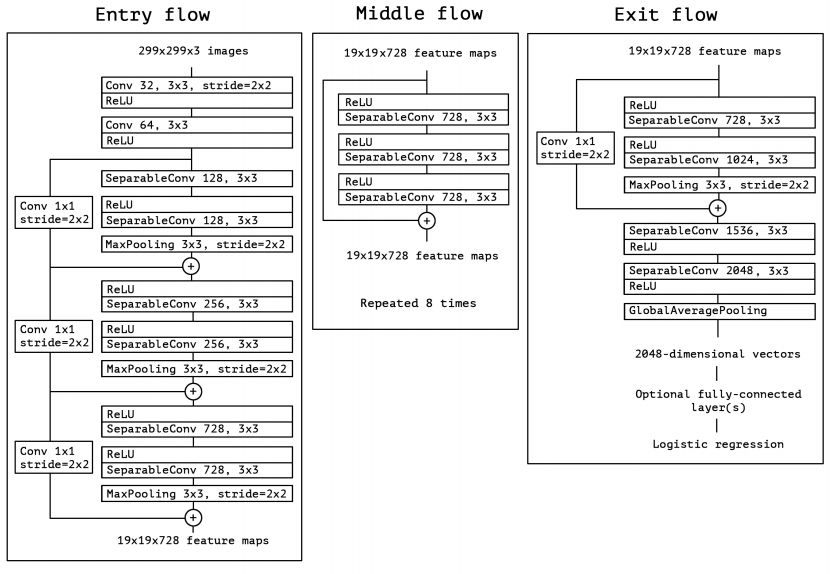

In [ ]:
#https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

class SeparableConv(nn.Module):
  """
  Modified and Xception-adapted version of the depthwise seperable convolution.
  It's basically a depthwise spacial convolution followed by a pointwise convolution.
  For a resulting outpout that we will call the SeperableConv.
  """
  def __init__(self, inputs, outputs,**kwargs):
        super().__init__()
        #majuscule utiliser pour le ouput de notre architecture a la fin qui est plus regulier
        #first depthwise spacial convolution
        self.DepthwiseConv = nn.Conv2d(
            inputs, 
            inputs,
            kernel_size=3, 
            padding=1, 
            groups=inputs, 
            bias=False,
            **kwargs)
        
        #pointwise convolution
        self.PointwiseConv = nn.Conv2d(
            inputs, 
            outputs,
            kernel_size=1, 
            bias=False,
            **kwargs)

  def forward(self, x):
        depthwise = self.DepthwiseConv(x)
        outpout = self.PointwiseConv(depthwise)
        return outpout

In [ ]:
######################################## TEST XCEPTION (V2)     ######################################

In [ ]:
#some of the variables names will have a  UpperCase on the variables first letters to have a final architecture that will follow the same etiquettes as in torch.nn
#source duquel on s'est inspirer: https://github.com/hoya012/pytorch-Xception/blob/master/Xception_pytorch.ipynb
class Entryflow(nn.Module):
    """
    This first flow will containt 4 blocs with a total of 2 convolutional layers,
    6 seperable convolutional layers and 3 skip-connections (shortcuts). ALl the activations will be Relu.
    Other than bloc1, all other 3 will have a MaxPooling Layer.
    """
    def __init__(self, input):

        super().__init__()
        #first bloc with the conv32 &conv 64 (see picture above of architecture)
        self.bloc1 = nn.Sequential(
            nn.Conv2d(input, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) 

        #seperableconv 128 followed by another seperableconv 138
        self.bloc2 = nn.Sequential(

            SeparableConv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SeparableConv(128, 128),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection1 = nn.Conv2d(64, 128, 1, 2, 0)

        #seperable conv 256 (x2)
        self.bloc3 = nn.Sequential(
            nn.ReLU(inplace=True),
            
            SeparableConv(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SeparableConv(256, 256),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection2 = nn.Conv2d(128, 256, 1, 2, 0)
        
        #separableconv 728 (x2))
        self.bloc4 = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv(256, 728),            
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection3 = nn.Conv2d(256, 728, 1, 2, 0)

    def forward(self, x):
      #do the 4 blocs +residuals :

        bloc1 = self.bloc1(x)
        bloc2_res = self.bloc2(bloc1) + self.SkipConnection1(bloc1)
        bloc3_res= self.bloc3(bloc2_res) + self.SkipConnection2(bloc2_res)
        out = self.bloc4(bloc3_res) + self.SkipConnection3(bloc3_res)
        return out
    

In [ ]:
class Middleflow(nn.Module):
    """
    This 2nd flow (the easiest one to understand) is a 3 times repetition of a separable conv with a relu activation
    """
    def __init__(self):

        super().__init__()
        # 3 times a separable conv with relu activation
        self.bloc8 = nn.Sequential(
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),            
                        
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728)
        )

    def forward(self, x):

        #we repeat the bloc 8 times like it is displayed in the picture of the architecture
        for i in range(8):
          x = self.bloc8(x) + x
        out=x
        return out


In [ ]:
class Exitflow(nn.Module):
    """
    This is the 3rd and final flow of the Xception architecture. It will have 2 blocs, one with 2 seperable conv with an addition of a skip-connection.
    Anothr bloc will contain 2 seperable conv and a global average pool.
    Finally we will have a fully connected  layer form a 2048-dimensional vectors + logicstic regression.
    """
    def __init__(self, classes):
        super().__init__()

        # BLoc 1 :two seperableconv : 728 followed by a 1024
        self.bloc1 = nn.Sequential(
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 1024),
            nn.BatchNorm2d(1024),
            
            nn.MaxPool2d(3, 2, 1)
        )

        #skip-connection of conv from bloc 1
        self.SkipConnection = nn.Conv2d(728, 1024, 1, 2, 0)
        
        #2nd bloc with only 2 seperableconv of 1536 and 2048.
        self.bloc2 = nn.Sequential(

            SeparableConv(1024, 1536),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            

            SeparableConv(1536, 2048),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )

        #majuscule pour larchitecture finale du fullyconnected layer

        #fully connected last layer
        self.FullyConnectedLayer = nn.Linear(2048, classes)
    def forward(self, x):
        x = self.bloc1(x) + self.SkipConnection(x)
        x = self.bloc2(x)
        #avg pool
        avg_pool = fonctional.adaptive_avg_pool2d(x, output_size=(1, 1))                
        global_avg_pool = avg_pool.view(avg_pool.size(0), -1)

        out = self.FullyConnectedLayer(global_avg_pool)
        
        return out  

In [ ]:
class Xception(nn.Module):
    def __init__(self, input, classes):
      super().__init__()
      #merging all 3 of the flows into creating the overall architecture of the Xception model
      self.entry=Entryflow(input)
      self.middle=Middleflow()
      self.exit=Exitflow(classes)
      
      # add logistic regression ???? 

    def forward(self,x):
      
      entry_flow= self.entry(x)
      middle_flow=self.middle(entry_flow)
      out=self.exit(middle_flow)

      return out

In [ ]:
net = Xception(3, 10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


exp_2 = Experiment(net)

for param in exp_2.model.parameters():
    param.requires_grad = True

In [ ]:
train_loader, validation_loader, test_loader=get_cifar10_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Let's visualize the architecture to make sure it is consistent with the architecture that we printed earlier
net


Xception(
  (entry): Entryflow(
    (bloc1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (bloc2): Sequential(
      (0): SeparableConv(
        (DepthwiseConv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (PointwiseConv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv(
        (DepthwiseConv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
    

As we can se we are able to reproduce the same architecture from scratch.  

COMMENT: (let's try adding the logistic regression layer at the end)

Voici nos sources pour notre code Xception:

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
https://github.com/hoya012/pytorch-Xception/blob/master/Xception_pytorch.ipynb
https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/xception.py


In [ ]:
# %%timeit
exp_2.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model_xception_',
                        num_epochs=10,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)

Epoch 1/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  1.2525334  Val Acc :  0.5542  Val f1 :  0.5542
Epoch 2/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.87399644  Val Acc :  0.693  Val f1 :  0.693
Epoch 3/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.74307066  Val Acc :  0.736  Val f1 :  0.736
Epoch 4/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.6393114  Val Acc :  0.7716  Val f1 :  0.7715999999999998
Epoch 5/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.56885266  Val Acc :  0.7994  Val f1 :  0.7994
Epoch 6/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.53739446  Val Acc :  0.8172  Val f1 :  0.8172
Epoch 7/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.47748682  Val Acc :  0.834  Val f1 :  0.834
Epoch 8/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.481687  Val Acc :  0.8336  Val f1 :  0.8336
Epoch 9/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.44224212  Val Acc :  0.8516  Val f1 :  0.8516
Epoch 10/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.4146599  Val Acc :  0.8564  Val f1 :  0.8564


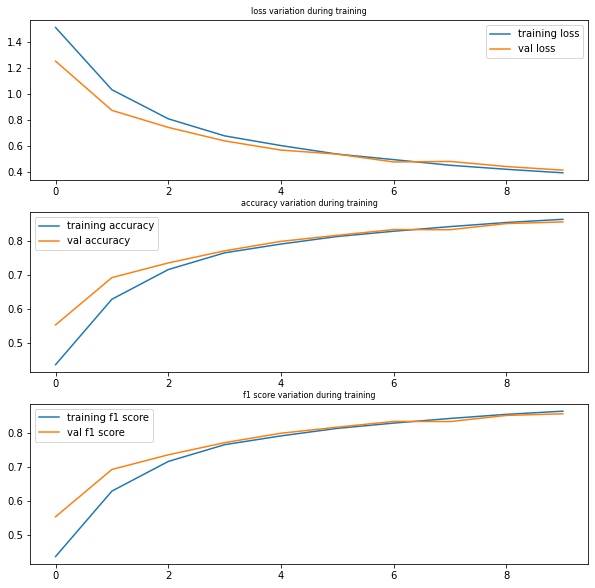

In [ ]:
exp_2.plot()

In [ ]:
#Without SIFT
exp_2.validate(test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

(0.4030838, 0.8657, 0.8657)

  0%|          | 0/500 [00:00<?, ?it/s]

f1 score :  0.8657
              precision    recall  f1-score   support

       plane       0.80      0.90      0.85      1000
         car       0.93      0.96      0.95      1000
        bird       0.84      0.79      0.81      1000
         cat       0.77      0.75      0.76      1000
        deer       0.93      0.77      0.84      1000
         dog       0.75      0.85      0.80      1000
        frog       0.93      0.90      0.92      1000
       horse       0.92      0.88      0.89      1000
        ship       0.91      0.93      0.92      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



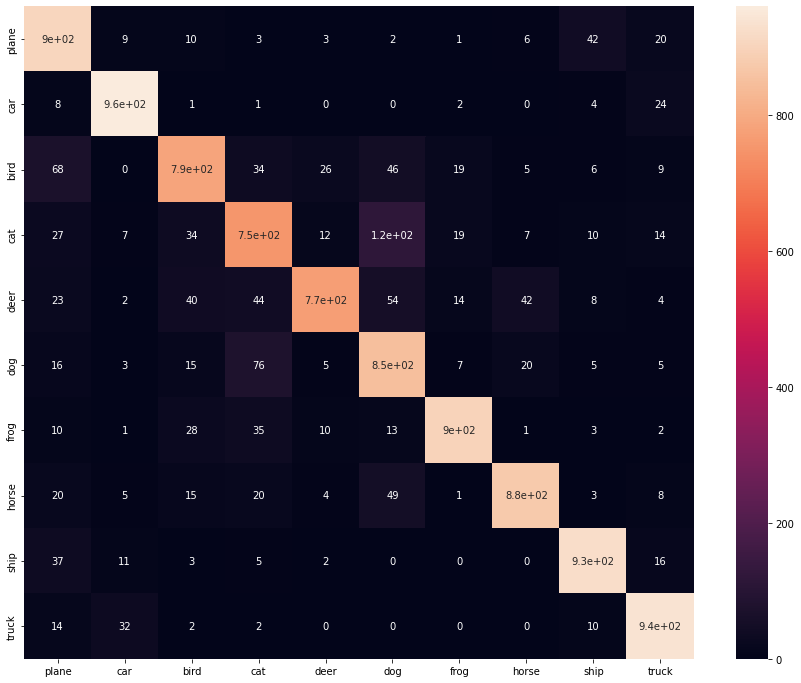

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat,y_true = exp_2.predict_loader(test_loader)
#y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(classes)))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(classes)],
                      columns = [i for i in list(classes)])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)